# 🐙 Standardizing CPUE with Generalized Additive Models and Tweedie GLMs  
*Understanding temporal and environmental drivers of Illex argentinus fisheries (2010–2020)*

---

### 📘 Overview  
This notebook lays the analytical foundation for understanding **temporal patterns in Illex argentinus catch data** across the Southwest Atlantic (2010–2020).  
It focuses on **Catch Per Unit Effort (CPUE)** — a core metric in fisheries science — and how it can be standardized to reveal true biological trends, free from distortions due to fishing effort, environmental variability, or spatial differences.

---

### 🎯 Objective  
The primary goal is to **model and standardize CPUE** to account for:
- Temporal variability (year, month),
- Spatial structure (latitude, longitude, depth),
- Environmental forcing (sea surface temperature, chlorophyll-a, sea surface height).

> **Note on Temporal Scope:**  
> To ensure comparability across years, analyses focus on data from **January to June** — the months consistently available across all years.  
> Later months (July–December) were excluded due to irregular sampling coverage.  
> This constraint ensures a **balanced temporal basis** for model training and interpretation, capturing **interannual trends within the early-season fishing period** rather than full-year dynamics.


By comparing multiple modeling frameworks — including **Generalized Additive Models (GAMs)**, **Gamma-GAMs**, and **Tweedie GLMs** — this analysis builds a transparent, reproducible workflow for identifying key drivers of catch variability and standardizing abundance indices.

---

### 🌍 Real-World Relevance  
Accurate CPUE standardization is essential for:
- **Stock assessment and quota setting**,  
- **Ecosystem-based fisheries management**, and  
- **Detecting climate-driven distribution shifts** in marine resources.  

Ultimately, this project demonstrates how advanced statistical modeling can strengthen decision-making for **sustainable fisheries** — bridging data science, marine ecology, and management.

---

## 🧮 Why GAMs and Tweedie GLMs?

Several statistical frameworks can be used to standardize CPUE, ranging from traditional Generalized Linear Models (GLMs) to advanced Bayesian hierarchical models.  
A notable benchmark study is **Lu et al. (2013)**, who applied a **Generalized Linear Bayesian Model (GLBM)** to standardize CPUE for *Illex argentinus*, incorporating environmental and spatial predictors within a Bayesian framework:

\[
\ln(\text{CPUE} + c) = \text{factor(Year)} + \text{factor(Month)} + s(\text{Longitude}) + s(\text{Latitude}) + s(\text{SST}) + s(\text{SSH}) + s(\text{Chl-a}) + \varepsilon
\]

where:  
- \( c \) is a small constant (≈10% of mean annual CPUE),  
- \( s() \) represents smooth spline functions capturing nonlinear effects,  
- \( \varepsilon \) is the residual error term.  

While Bayesian GLMs provide full probabilistic inference, they can be **computationally intensive** and require specialized probabilistic programming tools (*e.g.*, Stan, JAGS*).  
In contrast, this portfolio adopts **Generalized Additive Models (GAMs)** and **Tweedie GLMs** as **practical, interpretable alternatives** — capable of capturing similar nonlinear and distributional complexities without heavy computational demand.

---

### ⚙️ Model Motivation and Adaptation

| Model | Rationale | Strength |
|--------|------------|-----------|
| **Linear GAM** | Inspired by Lu et al. (2013); balances interpretability and flexibility. | Captures nonlinear environmental effects while maintaining linear additive structure. |
| **Gamma-GAM** | CPUE values are positive and right-skewed — ideal for Gamma family. | Provides smooth predictions without requiring log transformation. |
| **Tweedie GLM** | Handles zero-inflated and skewed distributions common in fisheries data. | Robust and generalizable; suitable for both sparse and dense catch datasets. |

---

### 💡 Why This Approach Works

- **Ecological realism** – Squid abundance responds nonlinearly to environment (thresholds, plateaus). GAMs handle this naturally.  
- **Statistical flexibility** – Tweedie GLMs and Gamma-GAMs accommodate non-normal, right-skewed CPUE distributions.  
- **Computational efficiency** – Practical for large fisheries datasets with tens of thousands of daily records.  
- **Transparency & reproducibility** – Results are interpretable and easy to communicate to stakeholders.  

---

> 🧠 *"By adopting GAMs and Tweedie GLMs, this project captures the ecological nuance of Illex argentinus dynamics — without sacrificing interpretability or reproducibility."*

---

### 📚 Reference  
Lu, C. C., Chen, C. S., Liu, K. M., & Yeh, S. Z. (2013).  
**Standardizing CPUE of Argentine shortfin squid (*Illex argentinus*) from the Taiwanese jigger fishery in the southwest Atlantic Ocean**.  
*Fisheries Research, 147*, 145–154.  
[https://doi.org/10.1016/j.fishres.2013.06.008](https://doi.org/10.1016/j.fishres.2013.06.008)

In [27]:

# ============================
# 1. Loading libraries
# ============================

# 📦 Core Packages
import os
#import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


# 📊 Statistical & ML Modeling
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

from pygam import LinearGAM, GammaGAM, s, f
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import bs  # for spline basis functions


# 🌐 Interactive Visualization
import plotly.graph_objects as go
import plotly.express as px


# ⚙️ Utility & Display Options
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)


# ✅ Environment Confirmation
print("Environment successfully initialized ✅")

Environment successfully initialized ✅


## 📂 Data Loading and Overview

Our dataset represents **Monthly Catch Per Unit Effort (CPUE)** for *Illex argentinus* (Argentine shortfin squid) from **2000–2020**.

Each record contains fishing effort, catch, and environmental variables such as:
- **WaterTemp** (Water Temperature./ sea surface temperature) per catch,
- **SSH** (Sea Surface Height) per month,
- **Depth** per catch,
- **Chlorophyll-a concentration** per month, and
- **Spatial coordinates (Latitude, Longitude)** per catch.

The goal is to assemble a clean, analysis-ready dataset that captures **spatio-temporal and environmental variability** relevant to CPUE standardization.

We'll:
1. Load the dataset  
2. Inspect basic structure (columns, datatypes, nulls) 
3. Conduct linear interpolation for missing environmental values
4. Calculate CPUE column which is squid catch in kg per day (due to the fact that there can be many catches per day) 
5. Subset the dataset to include only months with consistent data across all years for statistical analysis (Jan - Jun) based on data distribution summary from Temporal CPUE Analysis notebook.
6. Preview summary statistics and initial time coverage

In [28]:

# ============================
# 2. Load and Inspect Data
# ============================

# Load dataset
df = pd.read_csv("../data/Final_dataset.csv")

# Capitalize column names
#df.columns = [col.capitalize() for col in df.columns]

# Columns to impute
env_cols = ["Chlor_a_mg_m3", "Depth", "SSH"]

# Step 1️⃣: Create rounded coordinates for spatial grouping
df["Lon_round"] = df["Lon"].round(1)
df["Lat_round"] = df["Lat"].round(1)

# Step 2️⃣: Fill missing values with monthly mean (broad smoothing)
for col in env_cols:
    monthly_mean = df.groupby(["Year", "Month"])[col].transform("mean")
    df[col] = df[col].fillna(monthly_mean)

# Step 3️⃣: Linear interpolation within vessel-year-month-location group
for col in env_cols:
    df[col] = (
        df.groupby(["CTNO", "Year", "Month", "Lon_round", "Lat_round"], group_keys=False)[col]
          .apply(lambda x: x.interpolate(method="linear"))
          .values
    )

# Step 4️⃣: Fill remaining NAs forward/backward
for col in env_cols:
    df[col] = df[col].fillna(method="bfill").fillna(method="ffill")

# Step 5️⃣: Recreate date column
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

# Filter for Jan–June
df = df[df["Month"].between(1, 6)]

# Create CPUE per day
df["CPUE"] = df["SqCatch_Kg"] 

#log Transforming CPUE 
df["Log_CPUE"] = np.log(df["CPUE"])

# Step 6️⃣: Check missing values
print("\nMissing Values per Column After Imputation:")
print(df.isnull().sum())


# Save final dataset
df.to_csv("../data/Final_dataset_imputed.csv", index=False)
print("\n✅ Imputed dataset saved as 'Final_dataset_imputed.csv'")
# Temporal coverage

print(len(df),'rows')
print("\nDate Range:", df['Date'].min(), "to", df['Date'].max())


Missing Values per Column After Imputation:
POINTID          0
CTNO             0
Year             0
Month            0
Day              0
Lon              0
Lat              0
WaterTemp        0
SSH              0
Depth            0
Chlor_a_mg_m3    0
SqCatch_Kg       0
Lon_round        0
Lat_round        0
Date             0
CPUE             0
Log_CPUE         0
dtype: int64

✅ Imputed dataset saved as 'Final_dataset_imputed.csv'
163405 rows

Date Range: 2000-01-01 00:00:00 to 2020-05-28 00:00:00


## 🧹 Data Preparation and Preprocessing

Before modeling, we must prepare the CPUE dataset for statistical analysis.  
Fishing data often contain **extreme values** (e.g., high catches during short trips) and **incomplete environmental records** from satellite sensors.

In this step, we:
1. **Aggregate raw data** into monthly catch-per-unit-effort (CPUE) values.  
2. **Extract and merge relevant features** such as water temperature, depth, chlorophyll, and sea surface height.  
3. **Compute spatial summaries**, including CPUE-weighted average latitude and longitude for each month.
4. **Export clean, month-level data** for downstream analysis.

These steps convert raw catch logs and environmental inputs into a structured, model-ready dataset with one row per year-month.


In [ ]:
# Compute Monthly CPUE
monthly_cpue = (
    df.groupby(["Year", "Month"])
    .agg(
        TotalCatch=("CPUE", "sum"),
        DaysFished=("Day", "count")
    )
    .reset_index()
)
monthly_cpue["Monthly_CPUE"] = monthly_cpue["TotalCatch"] / monthly_cpue["DaysFished"]
monthly_cpue.sort_values(["Year", "Month"], inplace=True)
monthly_cpue.to_csv("../results/summaries/monthly_cpue.csv", index=False)

# Merge: WaterTemp and Depth (features to be averaged)
ftba = ["WaterTemp", "Depth"]
averaged_features = df.groupby(["Year", "Month"])[ftba].mean().reset_index()

# Merge: Already averaged features (SSH, Chlor_a)
aaf = ["SSH", "Chlor_a_mg_m3"]
already_averaged = df.groupby(["Year", "Month"])[aaf].first().reset_index()

#Data Preparation for EDA
EDA = monthly_cpue
EDA["Log_CPUE"] = np.log(EDA["Monthly_CPUE"])

# Merge all preprocessed features into a single dataset
EDA = (
    EDA
    .merge(averaged_features, on=["Year", "Month"])
    .merge(already_averaged, on=["Year", "Month"])
)


   Year  Month  TotalCatch  DaysFished  Monthly_CPUE  Log_CPUE  WaterTemp  \
0  2000      1   2.648e+07        2208     11994.460     9.392     13.668   
1  2000      2   6.533e+07        2803     23306.451    10.056     13.237   
2  2000      3   7.424e+07        3024     24550.438    10.108     12.107   
3  2000      4   3.706e+07        2932     12638.675     9.445     10.107   
4  2000      5   2.593e+07        2862      9060.496     9.112      8.798   

     Depth    SSH  Chlor_a_mg_m3  
0   76.642  0.020          0.904  
1   78.007  0.018          1.547  
2   84.642  0.015          0.690  
3   96.688  0.010          0.592  
4  107.336  0.011          0.443  


## 📊 Exploratory Visualization

Before modeling, it’s crucial to **visualize distributions** and **temporal patterns** in CPUE.  
This helps verify assumptions, detect anomalies, and justify model choices (e.g., using a Tweedie GLM for non-normal targets).

We'll visualize:
- **Distribution of CPUE** before and after log-transform  
- **Seasonal trends** across years  
- **Relationships** between CPUE and key predictors like WaterTemp and Chlorophyll_a
- **year-over-year trends** for each feature

This block is part of the **Exploratory Data Analysis (EDA)** phase — its goal is to:

- Understand the **distribution, variability, and structure** of the CPUE (Catch Per Unit Effort) data.  
- Check **data quality** indicators such as skewness, outliers, and the effect of transformations.  
- Identify **seasonal and environmental patterns** before applying models.
- Monitor the **seasonal trends in the environmental variables** over the years.

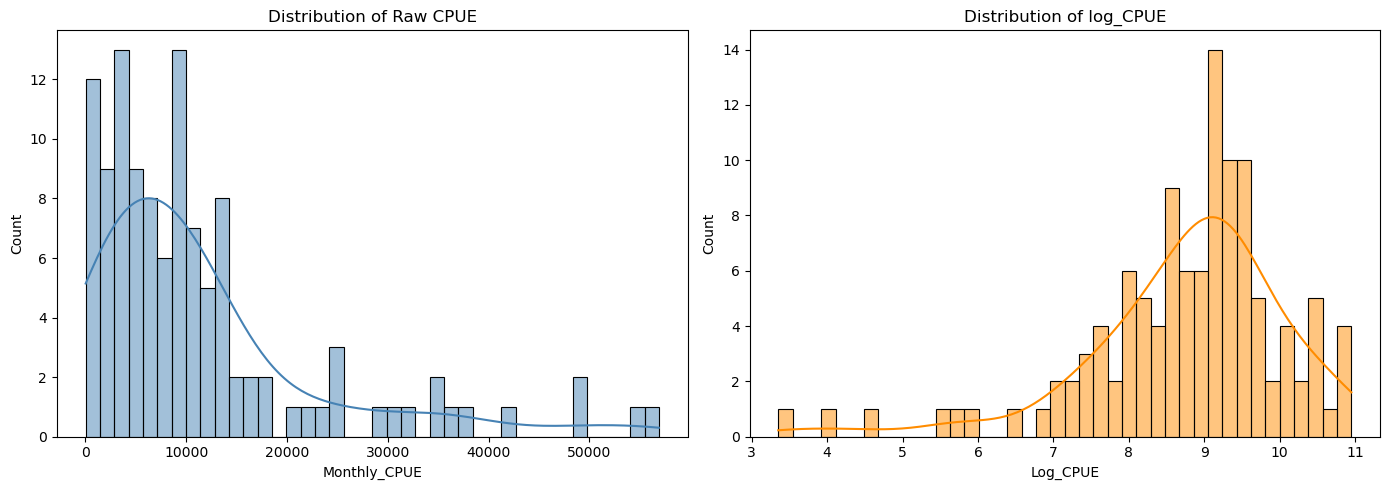

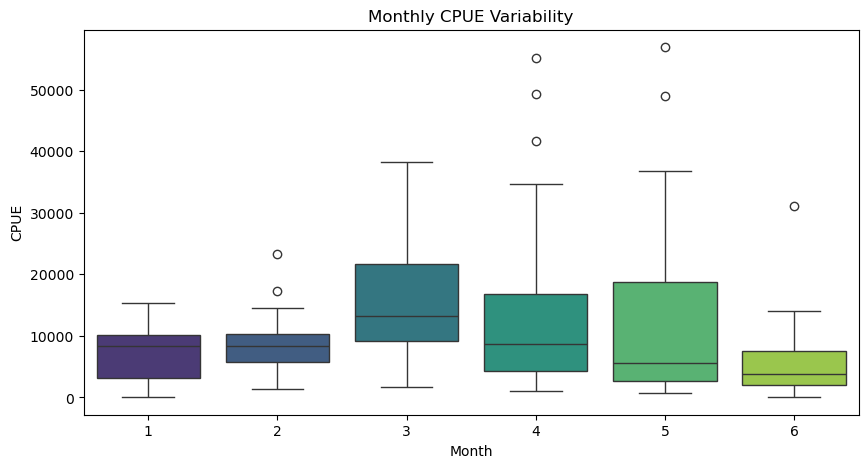

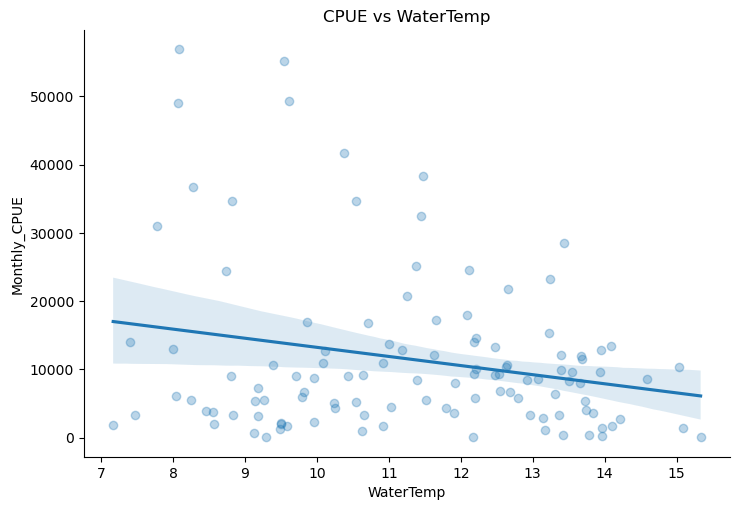

In [30]:
# ============================
# 5. Exploratory Visualization
# ============================

plt.figure(figsize=(14, 5))

# Distribution of raw CPUE
plt.subplot(1, 2, 1)
sns.histplot(EDA["Monthly_CPUE"], bins=40, color="steelblue", kde=True)
plt.title("Distribution of Raw CPUE")

# Distribution after log-transform
plt.subplot(1, 2, 2)
sns.histplot(EDA["Log_CPUE"], bins=40, color="darkorange", kde=True)
plt.title("Distribution of log_CPUE")

plt.tight_layout()
plt.show()

# Seasonal trend of CPUE
plt.figure(figsize=(10, 5))
sns.boxplot(x="Month", y="Monthly_CPUE", data=EDA, palette="viridis")
plt.title("Monthly CPUE Variability")
plt.xlabel("Month")
plt.ylabel("CPUE")
plt.show()

# Relationship between SST and CPUE
sns.lmplot(x="WaterTemp", y="Monthly_CPUE", data=EDA, height=5, aspect=1.5, scatter_kws={"alpha":0.3})
plt.title("CPUE vs WaterTemp")
plt.show()

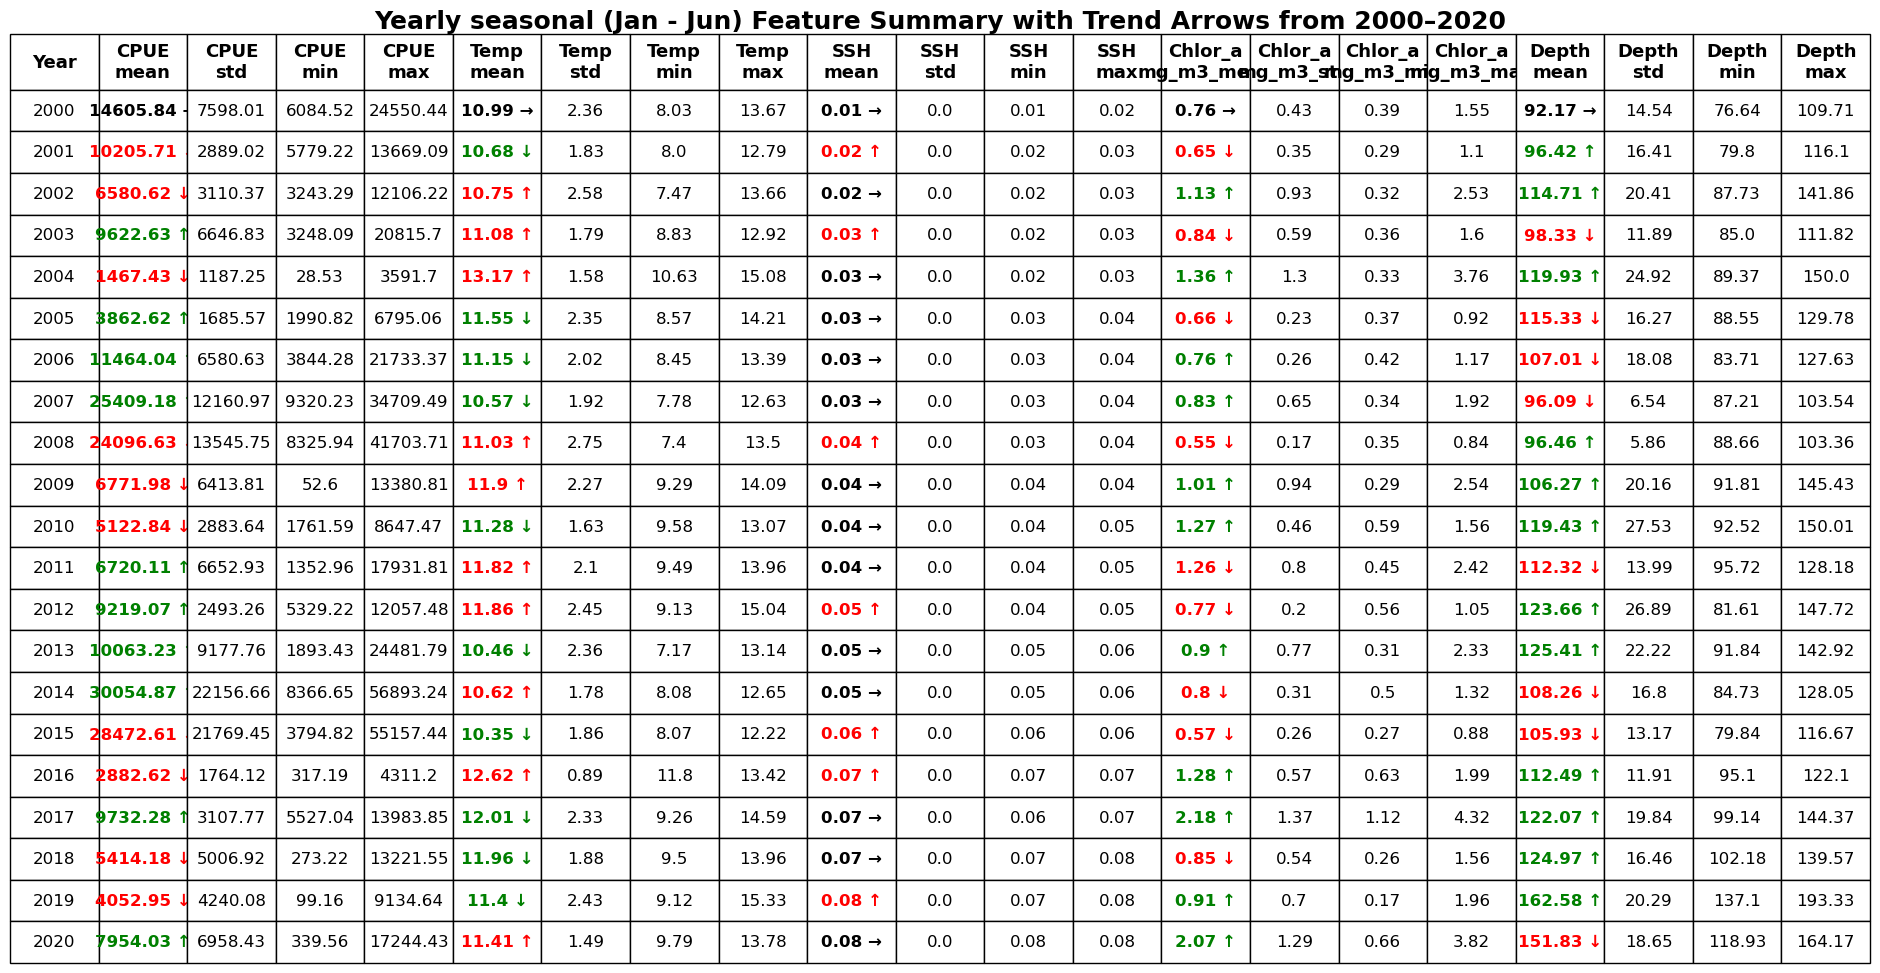

In [59]:
import matplotlib.pyplot as plt

# --- Step 1: Compute grouped statistics ---
cols_to_agg = ['Monthly_CPUE', 'WaterTemp', 'SSH', 'Chlor_a_mg_m3', 'Depth']
grouped_stats = EDA.groupby('Year')[cols_to_agg].agg(['mean', 'std', 'min', 'max'])
grouped_stats = grouped_stats.round(2)
grouped_stats.columns = ['_'.join(col).strip() for col in grouped_stats.columns.values]
grouped_stats.reset_index(inplace=True)

# --- Step 2: Add trend arrows to mean columns ---
numeric_features = ['Monthly_CPUE', 'WaterTemp', 'SSH', 'Depth', 'Chlor_a_mg_m3']
for feature in numeric_features:
    col = f"{feature}_mean"
    arrows = ['→']
    for i in range(1, len(grouped_stats)):
        prev = grouped_stats.loc[i - 1, col]
        curr = grouped_stats.loc[i, col]
        if curr > prev:
            arrows.append('↑')
        elif curr < prev:
            arrows.append('↓')
        else:
            arrows.append('→')
    grouped_stats[col] = grouped_stats[col].round(3).astype(str) + " " + arrows

# --- Step 3: Round other stats consistently ---
for feature in numeric_features:
    for stat in ['std', 'min', 'max']:
        col = f"{feature}_{stat}"
        if stat == 'std' or (stat == 'mean' and feature == 'SSH'):
            grouped_stats[col] = grouped_stats[col].round(4)
        else:
            grouped_stats[col] = grouped_stats[col].round(3)

# --- Step 4: Custom display names for table column headers ---
display_name_map = {
    'Monthly_CPUE': 'CPUE',
    'WaterTemp': 'Temp',
    'Chlor_a_mg_m3': 'Chlor_a',
    'SSH': 'SSH',
    'Depth': 'Depth'
}

def split_colname(name):
    parts = name.split('_', 2)
    if len(parts) == 2:
        feature, stat = parts
    elif len(parts) == 3:
        feature = parts[0] + '_' + parts[1]
        stat = parts[2]
    else:
        return name
    display_feature = display_name_map.get(feature, feature)
    return f"{display_feature}\n{stat}"

stacked_col_labels = [split_colname(col) for col in grouped_stats.columns]

# --- Step 5: Plot the summary table ---
fig, ax = plt.subplots(figsize=(24, 12))
ax.axis('off')
ax.axis('tight')

table = ax.table(
    cellText=grouped_stats.values,
    colLabels=stacked_col_labels,
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for key, cell in table.get_celld().items():
    if key[0] == 0:
        cell.set_text_props(weight='bold', fontsize=13)
        cell.set_height(0.06)
    else:
        cell.set_height(0.045)

plt.title("Yearly seasonal (Jan - Jun) Feature Summary with Trend Arrows from 2000–2020", fontsize=18, weight='bold')

# --- Step 6: Color the arrows ---
arrow_color_rules = {
    'WaterTemp':     {'↑': 'red', '↓': 'green', '→': 'black'},
    'SSH':           {'↑': 'red', '↓': 'green', '→': 'black'},
    'Monthly_CPUE':  {'↑': 'green', '↓': 'red', '→': 'black'},
    'Depth':         {'↑': 'green', '↓': 'red', '→': 'black'},
    'Chlor_a_mg_m3': {'↑': 'green', '↓': 'red', '→': 'black'}
}

for col_idx, col_name in enumerate(grouped_stats.columns):
    for feature, colors in arrow_color_rules.items():
        if col_name == f"{feature}_mean":
            for row_idx in range(1, len(grouped_stats) + 1):  # Skip header
                cell = table[row_idx, col_idx]
                text = cell.get_text().get_text()
                arrow = text[-1]  # Last char is the arrow
                color = colors.get(arrow, 'black')
                cell.get_text().set_color(color)
                cell.get_text().set_fontweight('bold')

# --- Step 7: Save and show ---
plt.savefig("../outputs/yearly_seasonal_feature_summary.png", dpi=300, bbox_inches='tight')
plt.show()


### 🧭 Interpretation of Results

#### **Distribution of Raw vs. Log CPUE**
- The raw CPUE is **right-skewed**, meaning it has a long tail to the **right** (a few very large catch values).  
  → This suggests that most fishing events, when aggregated monthly, yield modest catches, while a few exceptional ones dominate the totals.  
- After applying a **log transformation**, the distribution becomes approximately **normal**, which stabilizes variance and improves model fit — an essential step before regression-type analyses.

#### **Monthly CPUE Variability**
- The boxplot shows that **catch rates peak around March–May**, consistent with the seasonal migration and availability of *Illex argentinus*, particularly the South Patagonian Stock (SPS).  
- Wider interquartile ranges and outliers during these months indicate more variable fishing success — potentially driven by environmental or operational factors.

#### **CPUE vs. Water Temperature**
- The scatterplot with regression trend indicates a **slight negative relationship** — as **temperature increases**, CPUE tends to **decrease**.  
- This pattern aligns with the species’ preference for cooler waters and may point to **oceanographic drivers** influencing catch dynamics.

---

### Yearly Seasonal Feature Summary (2000–2020)

An analysis of seasonal (Jan–Jun) environmental variables over two decades reveals **long-term oceanographic shifts** that closely align with the **observed decline in CPUE**:

- **📉 CPUE Decline:** Despite interannual variability, **mean CPUE shows a downward trend**, suggesting reduced catchability or stock availability.

- **🌡️ Rising Water Temperature:** A steady **increase in mean water temperature** likely pushes squid away from traditional fishing areas, particularly in warmer years, reducing fleet efficiency.

- **🌊 Increasing Sea Surface Height (SSH):** SSH trends upward, potentially diminishing nutrient upwelling and disrupting the base of the food web — **indirectly lowering squid abundance or availability**.

- **🌱 Chlorophyll-a (Productivity) Fluctuations:** Primary productivity shows **no consistent correlation with CPUE** — in some years it rises while CPUE falls, suggesting a **decoupling of prey availability and squid presence**.

- **⏬ Deeper Fishing Depths:** Mean fishing depths have increased over time, indicating a possible **depth migration** of *Illex argentinus* in response to surface warming — making catches more difficult and reducing CPUE.

---

✅ **Summary Insight**  
The EDA confirms that CPUE is **highly variable**, **seasonally structured**, and **environmentally influenced**.  
The transformation and visualization steps justify the use of **non-Gaussian models** (e.g., Tweedie GLMs or GAMs) to capture the complex, skewed nature of catch data.

Importantly, the **yearly environmental feature trends from 2000–2020** — including **rising water temperatures**, **increasing sea surface height**, and **deeper fishing depths** — collectively suggest **climate-driven shifts** in *Illex argentinus* habitat. These changes likely reduce catchability and reinforce the need for **ecosystem-aware management** in future fishery assessments.


In [ ]:
# # Compute Monthly CPUE
# monthly_cpue = (
#     df.groupby(["Year", "Month"])
#     .agg(
#         TotalCatch=("CPUE", "sum"),
#         DaysFished=("Day", "count")
#     )
#     .reset_index()
# )
# monthly_cpue["Monthly_CPUE"] = monthly_cpue["TotalCatch"] / monthly_cpue["DaysFished"]
# monthly_cpue.sort_values(["Year", "Month"], inplace=True)

# monthly_cpue.to_csv("../results/summaries/monthly_cpue.csv", index=False)

# # Compute weighted average Latitude and Longitude per Year and Month
# def weighted_mean(group, value_col, weight_col):
#     return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

# weighted_coords = (
#     df.groupby(["Year", "Month"])
#     .apply(lambda g: pd.Series({
#         "Weighted_Latitude": weighted_mean(g, "Lat", "CPUE"),
#         "Weighted_Longitude": weighted_mean(g, "Lon", "CPUE")
#     }))
#     .reset_index()
# )

# # Merge back with features
# ftba = ["WaterTemp", "Depth"] # "ftba" stands for features to be avergaed
# aaf = ["SSH", "Chlor_a_mg_m3"] # "aaf" stands for already averaged features

# #Creating dataframes to merge after grouping them by months.
# averaged_features = df.groupby(["Year", "Month"])[ftba].mean().reset_index()
# already_averaged = df.groupby(["Year", "Month"])[aaf].first().reset_index()
# data = monthly_cpue.merge(averaged_features, on=["Year", "Month"]).merge(weighted_coords, on=["Year", "Month"]).merge(already_averaged, on=["Year", "Month"])
# data.head()

,Year,Month,TotalCatch,DaysFished,Monthly_CPUE,WaterTemp,Depth,Weighted_Latitude,Weighted_Longitude,SSH,Chlor_a_mg_m3
0,2000,1,2.588951e+07,2177,11892.288772,13.772538,76.641709,-46.533534,-60.723543,0.0201,0.903811
1,2000,2,6.305128e+07,2737,23036.638502,13.234984,78.006577,-47.162833,-61.276076,0.0178,1.546665
2,2000,3,7.175835e+07,2944,24374.440194,12.151003,84.641644,-47.567805,-60.756138,0.0150,0.690164
3,2000,4,3.532778e+07,2822,12518.701380,10.106035,96.687810,-48.823479,-61.871991,0.0097,0.591688
4,2000,5,2.437390e+07,2739,8898.831789,8.781864,107.336254,-47.660462,-61.109375,0.0109,0.442545


## ⚗️ Feature Engineering

Once the data are clean, we enhance them with engineered features to better capture ecological dynamics.  
CPUE distributions are typically **right-skewed**, with a few months showing very high catch rates. To address this, we apply **log transformations** to stabilize variance.

We also:
- Calculate the **mean yearly CPUE**, then use 10% of that as a small constant `c` to avoid log(0) errors.
- Generate two versions of log-transformed CPUE: `log(CPUE + c)` and `log(CPUE + 1)` for model comparison.
- Ensure data types (e.g., year as integer) are consistent and compatible with modeling libraries.
- Check for zero or negative CPUE values to inform model selection (e.g., Tweedie GLM if zeros are present).

These transformations improve model stability and ensure compatibility with both GAM and GLM families.

In [31]:
# Compute weighted Latitude and Longitude
def weighted_mean(group, value_col, weight_col):
    return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

weighted_coords = (
    df.groupby(["Year", "Month"])
    .apply(lambda g: pd.Series({
        "Weighted_Latitude": weighted_mean(g, "Lat", "CPUE"),
        "Weighted_Longitude": weighted_mean(g, "Lon", "CPUE")
    }))
    .reset_index()
)

# Merge all preprocessed features into a single dataset
data = (
    monthly_cpue
    .merge(averaged_features, on=["Year", "Month"])
    .merge(weighted_coords, on=["Year", "Month"])
    .merge(already_averaged, on=["Year", "Month"])
)

# Compute yearly mean CPUE
yearly_mean_cpue = data.groupby("Year")["Monthly_CPUE"].mean().rename("Yearly_Mean_CPUE")
data_df = data.merge(yearly_mean_cpue, on="Year")

# Compute log-transformed CPUE with two methods
data_df["c"] = 0.1 * data_df["Yearly_Mean_CPUE"]
data_df["Log_CPUE_plus_c"] = np.log(data_df["Monthly_CPUE"] + data_df["c"])
data_df["Log_CPUE_plus_1"] = np.log(data_df["Monthly_CPUE"] + 1)

# Define feature list for modeling
mod_features = [
    "Month", "Year", "Weighted_Latitude", "Weighted_Longitude",
    "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"
]

# Ensure correct data types
data_df["Year"] = data_df["Year"].astype(int)

# Copy final dataset to full_df for use in modeling
full_df = data_df.copy()

# Analyze zeros for model suitability
num_values_zero_and_below = (full_df["Monthly_CPUE"] <= 0).sum()
total_values = len(full_df)
print(f"Zero-or-below CPUE values: {num_values_zero_and_below} of {total_values}")

Zero-or-below CPUE values: 0 of 114


In [32]:
# Log-transform CPUE for Linear GAM (with c = 10% of mean yearly CPUE)
yearly_mean_cpue = (
    data.groupby("Year")["Monthly_CPUE"].mean()
)
yearly_mean_cpue.name = "Yearly_Mean_CPUE"

# Merge back to full data
data_df =  data.merge(yearly_mean_cpue, on="Year")

# finding 10% of Yearly_Mean_CPUE(constant/c) in data to avoid zero when log-transforming CPUE
data_df["c"] =  0.1 * data_df["Yearly_Mean_CPUE"]


#log Transforming the monthly CPUE + c then adding it to a new column in the full df
data_df["Log_CPUE_plus_c"] = np.log(data_df["Monthly_CPUE"] + data_df["c"])


#log Transforming the monthly CPUE + 1 then adding it to a new column in the full df
data_df["Log_CPUE_plus_1"] = np.log(data_df["Monthly_CPUE"] + 1)


# Features and Target
mod_features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]

# setting the "Year" column as integer
data_df["Year"] = data_df["Year"].astype(int)


#Making a copy of the full dataset for standardization
full_df = data_df

#Double checking if there are values that are zero or below in the full dataframe to know which methid aside from linear GAM takes priority for predictions
num_values_zero_and_below = (full_df["Monthly_CPUE"] <= 0).sum()
total_values = len(full_df["Monthly_CPUE"])

if num_values_zero_and_below == 0:
    print(f"Since there are:{num_values_zero_and_below} values out of {total_values} then it would be best to proceed with GammaGam and maybe consider TweedieGAM for outliers")
else:
    print(f"Since there are:{num_values_zero_and_below} values out of {total_values} then it would be best to proceed with TweedieGam")


Since there are:0 values out of 114 then it would be best to proceed with GammaGam and maybe consider TweedieGAM for outliers


## 🧠 Modeling Approaches: GAMs and GLMs

With the dataset prepared, we now **standardize and forecast CPUE** using a set of complementary models.  
All modeling was performed using **data from January–June (2000–2020)** — the months consistently available across all years — to ensure balanced and comparable temporal coverage.

### Why multiple models?
Each formulation captures different aspects of the data:

| Model | Transformation | Distribution | Purpose |
|:------|:----------------|:--------------|:---------|
| **LinearGAM (log(CPUE + c))** | Log-transform with small constant | Normal | Handles strong skew; simple and robust |
| **LinearGAM (log(CPUE + 1))** | Log-transform with +1 | Normal | Benchmark log-scaling |
| **GammaGAM** | Raw CPUE | Gamma | Appropriate for positive-only data with variance ∝ mean² |
| **TweedieGLM** | Raw CPUE | Tweedie | Flexible; interpolates between Poisson and Gamma — ideal for overdispersed fisheries data |

All models are trained and evaluated on the same dataset using consistent folds, metrics, and diagnostic checks.

---

### 📊 Purpose of Modeling

#### **1️⃣ Standardization**
We compare the observed CPUE against predictions standardized by each model.  
This helps **remove effort-related bias** and reveal the **true temporal and environmental patterns** in catch rates.

#### **2️⃣ Prediction**
We also use the trained models to **predict CPUE under new or future environmental conditions**.  
This provides **insight into expected fishery performance**, supports **management decisions**, and helps identify **environmental thresholds** that influence catch variability.

> Colors and legend conventions are kept consistent across all figures for interpretability.

In [33]:

# Modeling Setup
# Split: 2000-2014 (train), 2015-2020 (test)
train_df = full_df[full_df["Year"] < 2014].copy()
test_df = full_df[full_df["Year"] >= 2015].copy()

X_train = train_df[mod_features]
y_train = train_df["Monthly_CPUE"]
y_train_logC = train_df["Log_CPUE_plus_c"]
y_train_log1 = train_df["Log_CPUE_plus_1"]

X_test = test_df[mod_features]
y_test = test_df["Monthly_CPUE"]
y_test_logC = test_df["Log_CPUE_plus_c"]
y_test_log1 = test_df["Log_CPUE_plus_1"]

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 79, Testing samples: 30


In [ ]:

# model_summary_data = [
#     {
#         "Model_Name": "LinearGAM_log_CPUE_plus_c",
#         "Distribution": "Normal",
#         "Link_Function": "Identity",
#         "Target": "log(CPUE + c)",
#         "Notes": "Log transform with constant c to avoid log(0)"
#     },
#     {
#         "Model_Name": "LinearGAM_log_CPUE_plus_1",
#         "Distribution": "Normal",
#         "Link_Function": "Identity",
#         "Target": "log(CPUE + 1)",
#         "Notes": "Log transform with +1"
#     },
#     {
#         "Model_Name": "GammaGAM_CPUE",
#         "Distribution": "Gamma",
#         "Link_Function": "Log",
#         "Target": "CPUE",
#         "Notes": "Used Gamma distribution for skewed CPUE"
#     },
#     {
#         "Model_Name": "TweedieGLM_CPUE",
#         "Distribution": "Tweedie",
#         "Link_Function": "Log",
#         "Target": "CPUE",
#         "Notes": "Tweedie GLM for zero-inflated CPUE"
#     }
# ]

# model_summary = pd.DataFrame(model_summary_data)
# model_summary.to_csv("../results/summaries/model_summary.csv", index=False)


## 📈 Linear GAMs — Log-Transformed Models

We begin with two **Linear Generalized Additive Models (GAMs)** using log-transformed CPUE.  
The log transform helps stabilize variance and down-weight outliers while preserving multiplicative patterns in the original scale.

### Model details:
- **LinearGAM(log(CPUE + c))**: adds a small constant (`c = 0.1`) to avoid log(0)
- **LinearGAM(log(CPUE + 1))**: alternative log formulation for comparison
- Smoothers (`s()`) applied to environmental variables allow **nonlinear responses** to SST, SSH, depth, and chlorophyll.

We’ll fit both and evaluate later using RMSE and residual diagnostics.

In [34]:
# Standardization Using LinearGAM (log(CPUE + c))
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]

#Making a copy of the full dataset for standardization
full_df = data_df

#Subsetting full_df for only the features we would need to train the data
X_all = full_df[features]

# Target for LinearGAM 
y_all = full_df["Log_CPUE_plus_c"]

# Fit GLBM (GAM-like structure)
linear_gam_c_std = LinearGAM(f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))

# Fit the model on full data
linear_gam_c_std.fit(X_all, y_all)

# Predict standardized log(CPUE + c) for every row
linear_gam_c_all = linear_gam_c_std.predict(X_all)

# Back-transform to standardized CPUE
standardized_log_cpueC = np.exp(linear_gam_c_all) - full_df["c"]

# Store result
full_df["Standardized_log_cpueC"] = standardized_log_cpueC


In [35]:
# Prediction Using LinearGAM (log(CPUE + c))
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train = train_df[features]
X_test = test_df[features]

#log transforming data for training
y_train = np.log(train_df["Monthly_CPUE"] + train_df["c"])
y_test_linear = test_df["Monthly_CPUE"]  # for evaluation

# Fit GLBM (GAM-like structure)
linear_gam_c_prd = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))

# Train the model on part of the data
linear_gam_c_prd.fit(X_train, y_train)

# Predict log(CPUE + c) on test set
linear_gam_c_preds = linear_gam_c_prd.predict(X_test)

#Saving constant column for evaluation
lin_gam_c = test_df["c"]

# Back-transform to predicted CPUE (standardized)
linear_gam_c_preds_all = np.exp(linear_gam_c_preds) - lin_gam_c

#checking the amount of negatives values for glbm_preds
num_negatives = (linear_gam_c_preds_all < 0).sum()
total_preds = len(linear_gam_c_preds_all)
percent_negative = (num_negatives / total_preds) * 100

print(f"Negative predictions: {num_negatives} out of {total_preds} ({percent_negative:.2f}%)")

# 6 out of 29 predictions (20.69%) being negative means that about 1 in 5 predictions is unusable — which can bias results and understate CPUE trends hence why we clip to 0.
# The current LinearGAM with log-transformed CPUE (log(CPUE + c)) is not modeling the data well enough to avoid invalid predictions.

linear_gam_c_preds_all = linear_gam_c_preds_all.clip(lower=0)


Negative predictions: 12 out of 30 (40.00%)


In [36]:
# Standardization Using Linear_GAM (log(CPUE + 1))
# Select features used in the model 
features = ["Year", "Month", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]
X_all = full_df[features]

# Target for LinearGAM 
y_all = full_df["Log_CPUE_plus_1"]

# Fit the GAM model on full data
linear_gam_1_std = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_all, y_all)

# Predict on all data (standardized log(CPUE + 1))
linear_gam_1_all = linear_gam_1_std.predict(X_all)

# Back-transform to CPUE
standardized_log_cpue1 = np.exp(linear_gam_1_all) - 1

# Store result
full_df["Standardized_log_cpue1"] = standardized_log_cpue1



In [37]:
# Prediction Using LinearGAM GAM (log(CPUE + 1))

# Select features used in the model
features = ["Year", "Month","Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]

X_train = train_df[features]
X_test = test_df[features]

#log transforming data for training
y_train = np.log(train_df["Monthly_CPUE"] + 1)
y_test_linear = test_df["Monthly_CPUE"]  # for evaluation

# Fit GAM
linear_gam_1_prd = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_train, y_train)

# Predict on test
linear_gam_1_preds = linear_gam_1_prd.predict(X_test)
linear_gam_1_preds_all = np.exp(linear_gam_1_preds) - 1


## ⚖️ GammaGAM — Modeling Positive, Skewed CPUE

The **Gamma GAM** assumes that variance increases with the mean, making it suitable for **strictly positive** and **right-skewed** response variables like CPUE.

Unlike log-GAMs, this model operates directly on the original CPUE scale, avoiding back-transformation bias.  
It’s often used in fisheries standardization for abundance indices and effort-based normalization.

In [40]:
# Standardization Using GammaGAM
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]


# Features
X_all = full_df[features]

# Target for GammaGAM (no log-transform needed)
y_all = full_df["Monthly_CPUE"]

# Fit GammaGAM
# Because CPUE can vary sharply between months (e.g., seasonal fishing behavior, spawning), we will use a factor for flexibility.
# Since years often follow a longer trend (e.g., stock depletion, climate change) we will use a spline to prevent overfitting the yearly spikes and ensure better generalization to other years. This was seen in the trend from the time series EDA we could have seen that the yearly spikes are real but rare .
gamma_gam_std = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
gamma_gam_std.fit(X_all, y_all)

# Predict CPUE 
gamma_gam_std_all = gamma_gam_std.predict(X_all)

# Subtract the constant to get back standardized CPUE
standardized_cpue_GammaGAM = gamma_gam_std_all 

# Store result
full_df["Standardized_CPUE_GammaGAM"] = standardized_cpue_GammaGAM


In [39]:
# Prediction Using GammaGAM (general additive model, with spline automation defined only for positive and continuous outcomes)
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train = train_df[features]
X_test = test_df[features]

# Ensuring strictly positive CPUE by adding a small constant 
y_train = train_df["Monthly_CPUE"]
y_test_gamma = test_df["Monthly_CPUE"]  # for evaluation

# Training the model on part of the data (raw data)
gamma_gam_prd = GammaGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_train, y_train)

# Predict log(CPUE + c_glbm) on test set
gamma_gam_preds = gamma_gam_prd.predict(X_test)

## 🧩 Tweedie GLM — A Flexible Hybrid for Fisheries Data

The **Tweedie Generalized Linear Model** combines the strengths of Poisson and Gamma distributions,  
making it ideal for **zero-inflated** and **highly variable** positive data such as catch rates.

We use a **log link** and **variance power (`p ≈ 1.5–2.0`)**, suitable for overdispersed CPUE data.  
This model allows continuous prediction of CPUE while accommodating heavy tails and right skew.

In [41]:
# Standardization Using tweedieglm
# Create the formula with splines
formula = """
Monthly_CPUE ~ C(Month) + bs(Year, df=6) + bs(Weighted_Latitude, df=6) +
 bs(Weighted_Longitude, df=6) + bs(WaterTemp, df=6) + 
bs(Chlor_a_mg_m3, df=6) + bs(SSH, df=6) + bs(Depth, df=6)
"""

# Fit the model
tweedie_glm = smf.glm(formula=formula, data=full_df,
family=sm.families.Tweedie(var_power=1.5, link=sm.families.links.log())).fit()

# Predict
full_df["Standardized_CPUE_tweedieglm"] = tweedie_glm.predict(full_df)



In [ ]:
# Prediction Using tweedie_glm (glm with spline felxibility basis spline and full statitical output model, defined only for positive and continuous outcomes)
# Combine train and test for formula evaluation (since formula uses string-based feature names)
# train_df["split"] = "train"
# test_df["split"] = "test"

# # Combine train and test
# combined_df = pd.concat([train_df, test_df])
# test_df_tw = combined_df[combined_df["split"] == "test"]

# y_test_tweedie = test_df_tw["Monthly_CPUE"]  # for evaluation

# # Explicit bounds based on the full data
# # Reducing the degrees of freedom from 6 to 3 makes the spline smoother and less flexible, which often helps the model generalize better and thus improves the RMSE and MAE
# def bounded_bspline(var, df=4):
#     return f"bs({var}, df={df}, degree=3, include_intercept=False, " \
#            f"lower_bound={combined_df[var].min()}, upper_bound={combined_df[var].max()})"

# # Updated formula with explicit bounds
# formula = (
#     "Monthly_CPUE ~ C(Month) + " +
#     bounded_bspline("Year") + " + " +
#     bounded_bspline("Weighted_Latitude") + " + " +
#     bounded_bspline("Weighted_Longitude") + " + " +
#     bounded_bspline("WaterTemp") + " + " +
#     bounded_bspline("Chlor_a_mg_m3") + " + " +
#     bounded_bspline("SSH") + " + " +
#     bounded_bspline("Depth")
# )

# # Fit using training data
# tweedie_glm = smf.glm(formula=formula,
#                       data=combined_df[combined_df["split"] == "train"],
#                       family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()

# # Predict on test data
# tweedie_glm_pred = tweedie_glm.predict(combined_df[combined_df["split"] == "test"])

In [42]:
# Prediction Using tweedie_glm (glm with spline felxibility basis spline and full statitical output model, defined only for positive and continuous outcomes)
# Combine train and test for formula evaluation (since formula uses string-based feature names)
train_df["split"] = "train"
test_df["split"] = "test"

# Combine train and test
combined_df = pd.concat([train_df, test_df])


# Define which variables to scale (your spline terms)
vars_to_scale = [
    "Month", "Year", "Weighted_Latitude", "Weighted_Longitude",
    "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"
]

# Fit scaler on training data only
scaler = StandardScaler()
combined_df.loc[combined_df["split"] == "train", vars_to_scale] = scaler.fit_transform(
    combined_df.loc[combined_df["split"] == "train", vars_to_scale]
)

# Apply same transformation to test data
combined_df.loc[combined_df["split"] == "test", vars_to_scale] = scaler.transform(
    combined_df.loc[combined_df["split"] == "test", vars_to_scale]
)


# Clip test values to ensure they fall within training range (for safe spline application)
for var in vars_to_scale:
    train_min = combined_df.loc[combined_df["split"] == "train", var].min()
    train_max = combined_df.loc[combined_df["split"] == "train", var].max()
    combined_df.loc[combined_df["split"] == "test", var] = combined_df.loc[
        combined_df["split"] == "test", var
    ].clip(lower=train_min, upper=train_max)



# Saving test variable  
test_df_tw = combined_df[combined_df["split"] == "test"]
y_test_tweedie = test_df_tw["Monthly_CPUE"]  # for evaluation


# Explicit bounds based on the full data
# Reducing the degrees of freedom from 6 to 3 makes the spline smoother and less flexible, which often helps the model generalize better and thus improves the RMSE and MAE
def bounded_bspline(var, df=4):
    train_vals = combined_df[combined_df["split"] == "train"][var]
    return (
        f"bs({var}, df={df}, degree=3, include_intercept=False, "
        f"lower_bound={train_vals.min()}, upper_bound={train_vals.max()})"
    )

# Updated formula with explicit bounds
formula = (
    "Monthly_CPUE ~ C(Month) + " +
    bounded_bspline("Year") + " + " +
    bounded_bspline("Weighted_Latitude") + " + " +
    bounded_bspline("Weighted_Longitude") + " + " +
    bounded_bspline("WaterTemp") + " + " +
    bounded_bspline("Chlor_a_mg_m3") + " + " +
    bounded_bspline("SSH") + " + " +
    bounded_bspline("Depth")
)

# Fit using training data
tweedie_glm = smf.glm(formula=formula,
                      data=combined_df[combined_df["split"] == "train"],
                      family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()

# Predict on test data
tweedie_glm_pred = tweedie_glm.predict(combined_df[combined_df["split"] == "test"])

## 📊 Model Evaluation — Comparing Predictive Performance

To identify the most reliable CPUE standardization model, we evaluate each candidate (GAMs and GLMs) on a **held-out test set** and through **5-fold cross-validation**.

### Metrics Used:
- **Root Mean Squared Error (RMSE):** Penalizes large deviations heavily.
- **Mean Absolute Error (MAE):** Measures average prediction deviation.
- **R² Score:** Indicates proportion of variance explained.

These metrics are computed both on the **transformed scale** (for model fit) and on the **original CPUE scale** (for interpretability).

In [43]:
#Evaluation (RMSE & MAE)
results = pd.DataFrame({
    "Model": ["GAM(log(CPUE+c))","GAM(log(CPUE+1))", "GammaGAM", "Tweedie_GLM"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_linear, linear_gam_c_preds_all)),
        np.sqrt(mean_squared_error(y_test_linear, linear_gam_1_preds_all)),
        np.sqrt(mean_squared_error(y_test_gamma, gamma_gam_preds)),
        np.sqrt(mean_squared_error(y_test_tweedie, tweedie_glm_pred))
    ],
    "MAE": [
        mean_absolute_error(y_test_linear, linear_gam_c_preds_all),
        mean_absolute_error(y_test_linear, linear_gam_1_preds_all),
        mean_absolute_error(y_test_gamma, gamma_gam_preds),
        mean_absolute_error(y_test_tweedie, tweedie_glm_pred)
    ]
})

pd.options.display.float_format = '{:,.2f}'.format
print(results)
results.to_csv("../results/summaries/eval_results.csv", index=False)
pd.reset_option('display.float_format') 

              Model      RMSE       MAE
0  GAM(log(CPUE+c)) 16,673.29 10,089.47
1  GAM(log(CPUE+1)) 15,986.24  9,638.06
2          GammaGAM 15,687.70  9,304.71
3       Tweedie_GLM 13,281.71  8,176.55


## 🔁 5-Fold Cross-Validation

To ensure that model performance generalizes beyond a single train/test split,  
we perform **5-fold cross-validation** for each model.

This step helps confirm that the selected model is **robust** and not tuned to specific years or environmental conditions.

> Fisheries time series often show interannual autocorrelation — so we use folds that respect temporal ordering to minimize leakage.

In [45]:

#Cross Validation (RMSE) using 5 folds

# Scoring function for RMSE:
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(compute_rmse, greater_is_better=False)


# LinearGAM (log-transformed CPUE + c)
features_c = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X = data_df[features_c].values
y = data_df["Log_CPUE_plus_c"].values
c_series = full_df["c"].values  # full Series of c values (same length as X)

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_gam_c_rmse_scores = []

# Manual CV loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    c_test = c_series[test_index]  # ✨ Grab matching c values for the test se
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
    gam.fit(X_train, y_train)
    lin_gam_c_preds = gam.predict(X_test)
    lin_gam_c_preds_all = np.exp(lin_gam_c_preds) - c_test
    rmse = np.sqrt(mean_squared_error(y_test, lin_gam_c_preds_all))
    lin_gam_c_rmse_scores.append(rmse)

print("LinearGAM_c Mean RMSE:", np.mean(lin_gam_c_rmse_scores))

# LinearGAM (log-transformed CPUE + 1)
features_1 = ["Year", "Month", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]
X = data_df[features_1].values
y = data_df["Log_CPUE_plus_1"].values

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_gam_1_rmse_scores = []

# Manual CV loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
    gam.fit(X_train, y_train)
    lin_gam_c_preds = gam.predict(X_test)
    lin_gam_1_preds_all = np.exp(lin_gam_c_preds) - 1
    rmse = np.sqrt(mean_squared_error(y_test,lin_gam_1_preds_all))
    lin_gam_1_rmse_scores.append(rmse)

print("LinearGAM_1 Mean RMSE:", np.mean(lin_gam_1_rmse_scores))

#GammaGAM (raw CPUE, no log)
X = data_df[features_c]
y = data_df["Monthly_CPUE"]
gam_gamma = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
scores_gamma = cross_val_score(gam_gamma, X, y, cv=5, scoring=rmse_scorer)
print("GammaGAM Mean RMSE:", -np.mean(scores_gamma))


#TweedieGAM (raw CPUE, more robust to outliers)

# List of spline-transformed variables
vars_to_scale = [
    "Month", "Year", "Weighted_Latitude", "Weighted_Longitude",
    "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"
]

tweedie_rmse_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_df_cv = X_train.copy()
    train_df_cv["Monthly_CPUE"] = y_train
    
    test_df_cv = X_test.copy()
    test_df_cv["Monthly_CPUE"] = y_test

       # Standardize using only training fold
    scaler = StandardScaler()
    train_df_cv[vars_to_scale] = scaler.fit_transform(train_df_cv[vars_to_scale])
    test_df_cv[vars_to_scale] = scaler.transform(test_df_cv[vars_to_scale])

    # Clip test fold to training fold min/max
    for var in vars_to_scale:
        train_min = train_df_cv[var].min()
        train_max = train_df_cv[var].max()
        test_df_cv[var] = test_df_cv[var].clip(lower=train_min, upper=train_max)


     # Define bounded spline terms
    def bounded_bspline(var, df=4):
        train_vals = train_df_cv[var]
        return (
            f"bs({var}, df={df}, degree=3, include_intercept=False, "
            f"lower_bound={train_vals.min()}, upper_bound={train_vals.max()})"
        )

    # Build formula dynamically
    formula = (
        "Monthly_CPUE ~ C(Month) + " +
        bounded_bspline("Year") + " + " +
        bounded_bspline("Weighted_Latitude") + " + " +
        bounded_bspline("Weighted_Longitude") + " + " +
        bounded_bspline("WaterTemp") + " + " +
        bounded_bspline("Chlor_a_mg_m3") + " + " +
        bounded_bspline("SSH") + " + " +
        bounded_bspline("Depth")
    )

    model = smf.glm(formula=formula,
                    data=train_df_cv,
                    family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()
    
     # Predict on test fold
    y_pred_tw = model.predict(test_df_cv)
    tweedie_rmse_scores.append(compute_rmse(y_test, y_pred_tw))

print("TweedieGAM Mean RMSE:", np.mean(tweedie_rmse_scores))

# Storing and rounding all mean RMSE scores
cv_summary = pd.DataFrame({
    "Model": [
        "LinearGAM_log_cpueC",
        "LinearGAM_log_cpue1",
        "GammaGAM",
        "TweedieGAM"
    ],
    "Mean_RMSE": [
        round(np.mean(lin_gam_c_rmse_scores), 2),
        round(np.mean(lin_gam_1_rmse_scores), 2),
        round(-np.mean(scores_gamma), 2),  # negate because scorer is negative
        round(np.mean(tweedie_rmse_scores), 2)
    ]
})

# Save to CSV
cv_summary.to_csv("../results/summaries/cv_results.csv", index=False)

LinearGAM_c Mean RMSE: 12921.299538099152
LinearGAM_1 Mean RMSE: 15414.116211110904
GammaGAM Mean RMSE: 11211.467511101093
TweedieGAM Mean RMSE: 12533.842729331647


## 📈 Standardized CPUE Over Time

We compare the observed CPUE against predictions standardized by each model.  
This helps illustrate how models remove **effort bias** and capture underlying temporal trends in fishery data.

> Colors are kept consistent across all figures for clarity.

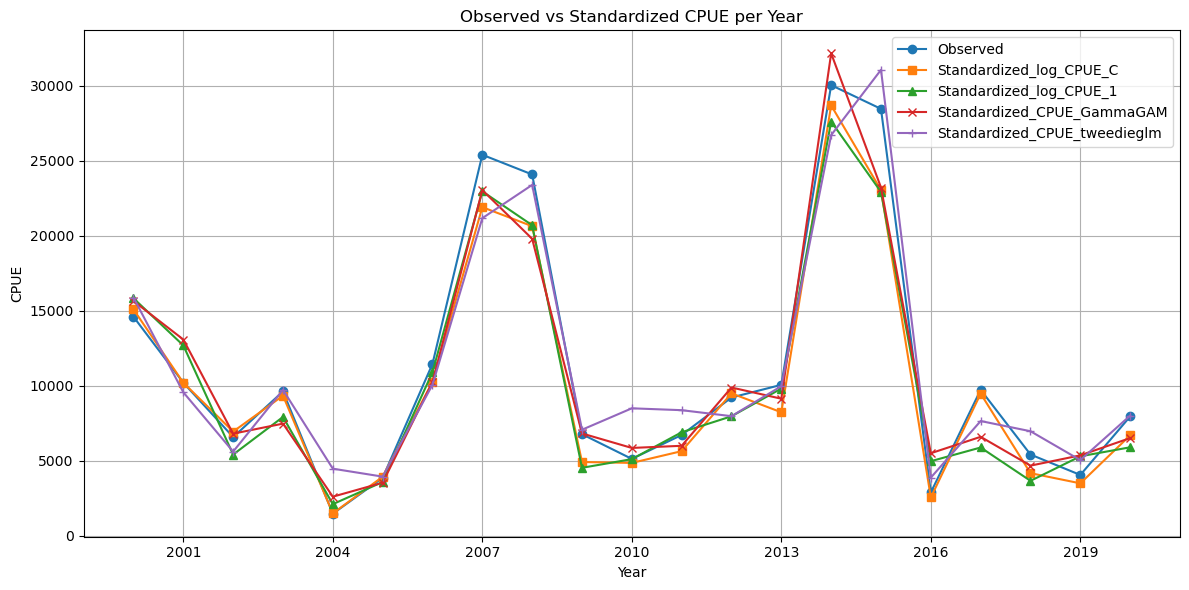

In [50]:
# 6. Visualization for Standardization

# Define consistent colors for each series
colors = {
    "Observed": "#1f77b4",                    # blue
    "Standardized_log_cpueC": "#ff7f0e",      # orange
    "Standardized_log_cpue1": "#2ca02c",      # green
    "Standardized_CPUE_GammaGAM": "#d62728",  # red
    "Standardized_CPUE_tweedieglm": "#9467bd" # purple
}

# Yearly Standardized vs Observed
yearly = full_df.groupby("Year")["Monthly_CPUE"].mean().reset_index(name="Observed")

yearly_log_cpueC = full_df.copy()
#yearly_log_cpueC["Standardized_log_cpueC"] = standardized_log_cpueC
yearly_log_cpueC = yearly_log_cpueC.groupby("Year")["Standardized_log_cpueC"].mean().reset_index()

yearly_log_cpue1 = full_df.copy()
#yearly_log_cpue1["Standardized_log_cpue1"] = standardized_log_cpue1
yearly_log_cpue1 = yearly_log_cpue1.groupby("Year")["Standardized_log_cpue1"].mean().reset_index()

yearly_cpue_gamma_c = full_df.copy()
#yearly_cpue_gamma_c["GammaGAM_Standardized"] = standardized_cpue_gamma_c
yearly_cpue_gamma_c = yearly_cpue_gamma_c.groupby("Year")["Standardized_CPUE_GammaGAM"].mean().reset_index()

yearly_cpue_gamma_1 = full_df.copy()
#yearly_cpue_gamma_1["GammaGAM_Standardized"] = standardized_cpue_gamma_1
yearly_cpue_gamma_1 = yearly_cpue_gamma_1.groupby("Year")["Standardized_CPUE_tweedieglm"].mean().reset_index()

merged = yearly.merge(yearly_log_cpueC, on="Year").merge(yearly_log_cpue1, on="Year").merge(yearly_cpue_gamma_c, on="Year").merge(yearly_cpue_gamma_1, on="Year")

# Save observed + standardized CPUE data by year to CSV
merged.to_csv("../results/summaries/observed_vs_standardized.csv", index=False)

# Interactive observed vs standardized plot
fig_os = go.Figure()

# Add each trace manually using the defined colors
for name in colors:
    fig_os.add_trace(
        go.Scatter(
            x=merged["Year"],
            y=merged[name],
            mode="lines+markers",
            name=name,
            line=dict(color=colors[name])
        )
    )

# Layout
fig_os.update_layout(
    title="Observed vs Standardized CPUE per Year",
    xaxis=dict(title="Year", tickformat=".0f"),
    yaxis_title="CPUE",
    legend_title="Series",
    hovermode="x unified",
    width=1000,
    height=900
)

fig_os.show()


# Static observed vs standardized plot
plt.figure(figsize=(12, 6))
plt.plot(merged["Year"], merged["Observed"], label="Observed", marker="o", color=colors["Observed"])
plt.plot(merged["Year"], merged["Standardized_log_cpueC"], label="Standardized_log_CPUE_C", marker="s", color=colors["Standardized_log_cpueC"])
plt.plot(merged["Year"], merged["Standardized_log_cpue1"], label="Standardized_log_CPUE_1", marker="^", color=colors["Standardized_log_cpue1"])
plt.plot(merged["Year"], merged["Standardized_CPUE_GammaGAM"], label="Standardized_CPUE_GammaGAM", marker="x", color=colors["Standardized_CPUE_GammaGAM"])
plt.plot(merged["Year"], merged["Standardized_CPUE_tweedieglm"], label="Standardized_CPUE_tweedieglm", marker="+", color=colors["Standardized_CPUE_tweedieglm"])
plt.title("Observed vs Standardized CPUE per Year")
plt.ylabel("CPUE")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## 📊 Actual vs Predicted CPUE — Test Set Comparison

Here we plot the observed CPUE against model predictions on the **test set**.  
This allows visual inspection of model performance and highlights potential under/overprediction trends.

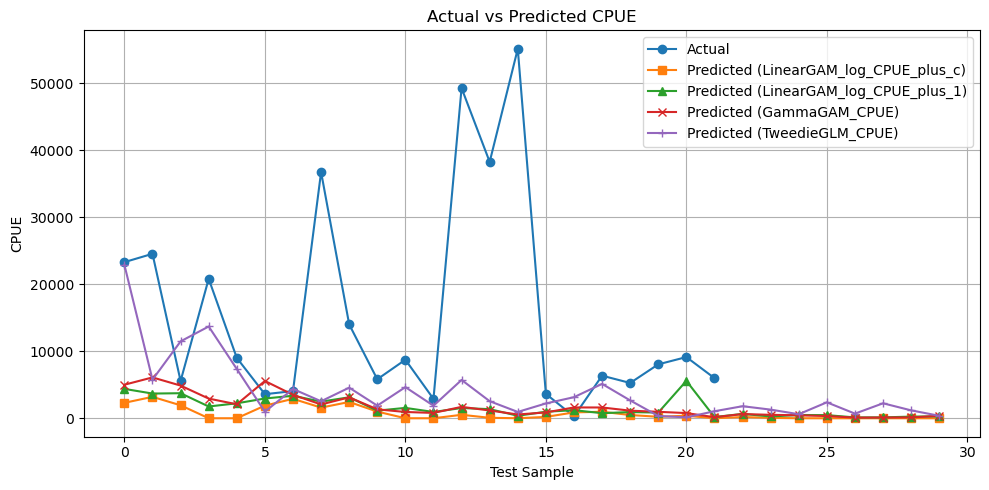

In [51]:
# Visualization for Prediction plots
# Consistent colors for each series
colors = {
    "Actual": "#1f77b4",                                      # blue
    "Predicted (LinearGAM_log_CPUE_plus_c)": "#ff7f0e",       # orange
    "Predicted (LinearGAM_log_CPUE_plus_1)": "#2ca02c",       # green
    "Predicted (GammaGAM_CPUE)": "#d62728",                   # red
    "Predicted (TweedieGLM_CPUE)": "#9467bd"                  # purple
}


# x-axis index for all predictions
x = list(range(len(y_test)))
x_linear = list(range(len(y_test_linear)))  # linear_gam
x_gamma = list(range(len(y_test_gamma))) # gamma
x_tweedie = list(range(len(y_test_tweedie)))  # tweedie

# Create interactive figure
fig_ap = go.Figure()

fig_ap.add_trace(go.Scatter(x=x, y=y_test.values, mode='lines+markers', name='Actual',
                         marker=dict(symbol='circle'), line=dict(color=colors["Actual"])))
fig_ap.add_trace(go.Scatter(x=x_linear, y=linear_gam_c_preds_all, mode='lines+markers',
                         name='Predicted (LinearGAM_log_CPUE_plus_c)',
                         marker=dict(symbol='square'), line=dict(color=colors["Predicted (LinearGAM_log_CPUE_plus_c)"])))
fig_ap.add_trace(go.Scatter(x=x_linear, y=linear_gam_1_preds_all, mode='lines+markers',
                         name='Predicted (LinearGAM_log_CPUE_plus_1)',
                         marker=dict(symbol='triangle-up'), line=dict(color=colors["Predicted (LinearGAM_log_CPUE_plus_1)"])))
fig_ap.add_trace(go.Scatter(x=x_gamma, y=gamma_gam_preds, mode='lines+markers',
                         name='Predicted (GammaGAM_CPUE)',
                         marker=dict(symbol='x'), line=dict(color=colors["Predicted (GammaGAM_CPUE)"])))
fig_ap.add_trace(go.Scatter(x=x_tweedie, y=tweedie_glm_pred, mode='lines+markers',
                         name='Predicted (TweedieGLM_CPUE)',
                         marker=dict(symbol='cross'), line=dict(color=colors["Predicted (TweedieGLM_CPUE)"])))

fig_ap.update_layout(
    title='Actual vs Predicted CPUE (Interactive)',
    xaxis_title='Test Sample Index',
    yaxis_title='CPUE',
    hovermode='x unified',
    legend_title='Legend',
    template='plotly_white'
)
fig_ap.show()



# C. Actual vs Predicted Plot static plot
x = range(len(y_test))  # common for all
x_linear = range(len(y_test_linear))  # linear_gam
x_gamma = range(len(y_test_gamma))  # gamma
x_tweedie = range(len(y_test_tweedie))  # tweedie
plt.figure(figsize=(10, 5))
plt.plot(x, y_test.values, label="Actual", marker="o", color=colors["Actual"])
plt.plot(x_linear, linear_gam_c_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_c)", marker="s", color=colors["Predicted (LinearGAM_log_CPUE_plus_c)"])
plt.plot(x_linear, linear_gam_1_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_1)", marker="^", color=colors["Predicted (LinearGAM_log_CPUE_plus_1)"])
plt.plot(x_gamma, gamma_gam_preds, label="Predicted (GammaGAM_CPUE)", marker="x", color=colors["Predicted (GammaGAM_CPUE)"])
plt.plot(x_tweedie, tweedie_glm_pred, label="Predicted (TweedieGLM_CPUE)", marker="+", color=colors["Predicted (TweedieGLM_CPUE)"])
plt.title("Actual vs Predicted CPUE")
plt.ylabel("CPUE")
plt.xlabel("Test Sample")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

prediction_data = {
    "Actual": (x, y_test.values),
    "Predicted (LinearGAM_log_CPUE_plus_c)": (x_linear, linear_gam_c_preds_all),
    "Predicted (LinearGAM_log_CPUE_plus_1)": (x_linear, linear_gam_1_preds_all),
    "Predicted (GammaGAM_CPUE)": (x_gamma, gamma_gam_preds),
    "Predicted (TweedieGLM_CPUE)": (x_tweedie, tweedie_glm_pred),
}

color_dict = {
    "Actual": "#1f77b4",
    "Predicted (LinearGAM_log_CPUE_plus_c)": "#ff7f0e",
    "Predicted (LinearGAM_log_CPUE_plus_1)": "#2ca02c",
    "Predicted (GammaGAM_CPUE)": "#d62728",
    "Predicted (TweedieGLM_CPUE)": "#9467bd",
}

np.savez("../results/summaries/prediction_data.npz",
         pred_dict=prediction_data,
         color_dict=color_dict)
 
 #--- Fixing prediction_data.npz ---
data = np.load("../results/summaries/prediction_data.npz", allow_pickle=True)
pred_dict = data["pred_dict"].item()
color_dict = data["color_dict"].item()

# Convert all items to lists to avoid issues with non-serializable types
cleaned_pred_dict = {}
for k, v in pred_dict.items():
    if isinstance(v, tuple):
        x, y = v
        x_clean = list(x) if not isinstance(x, list) else x
        y_clean = list(y) if not isinstance(y, list) else y
        cleaned_pred_dict[k] = (x_clean, y_clean)
    else:
        cleaned_pred_dict[k] = v

np.savez("../results/summaries/prediction_data_clean.npz",
         pred_dict=cleaned_pred_dict,
         color_dict=color_dict)

## 🔍 Residual Analysis — Checking Model Assumptions

Residual diagnostics help determine whether each model has captured the key structure in the data.

We examine:
- **Residual vs Fitted plots:** to detect heteroskedasticity or nonlinearities.
- **Distribution of residuals:** to confirm approximate normality (for Gaussian-based models).
- **Temporal patterns:** to verify absence of autocorrelation across years.

A good model should show **random, pattern-free residuals**, indicating that remaining variation is mostly stochastic.

## 🔍 Residual Plots — Checking Model Fit

Residuals = Observed - Predicted.  

By plotting residuals, we detect:
- Bias across prediction range
- Extreme outliers
- Patterns suggesting model misfit

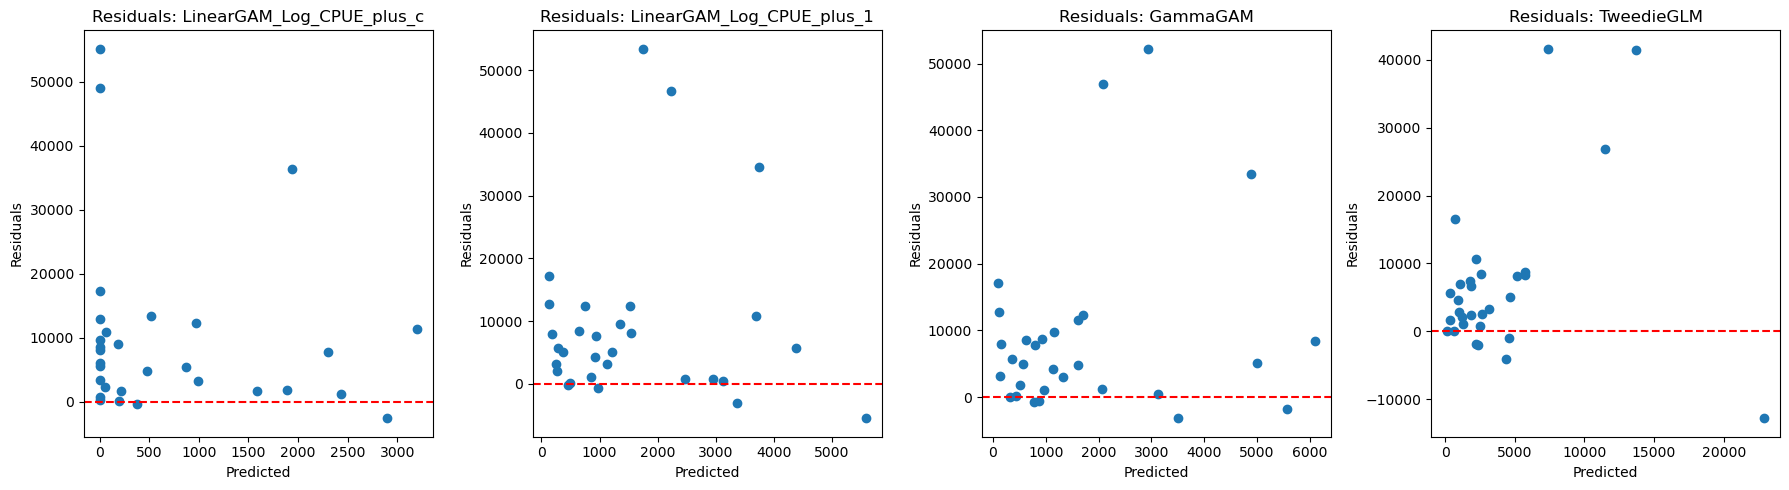

In [48]:
# B. Visualization for Residual Plots
residuals_linear_GAM_log_CPUE_plus_c = y_test_linear - linear_gam_c_preds_all
residuals_linear_GAM_log_CPUE_plus_1 = y_test_linear - linear_gam_1_preds_all
residuals_Gamma_GAM = y_test_gamma - gamma_gam_preds
residuals_Tweedie_GLM = y_test_tweedie - tweedie_glm_pred


plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.scatter(linear_gam_c_preds_all, residuals_linear_GAM_log_CPUE_plus_c)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: LinearGAM_Log_CPUE_plus_c")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 2)
plt.scatter(linear_gam_1_preds_all, residuals_linear_GAM_log_CPUE_plus_1)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: LinearGAM_Log_CPUE_plus_1")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 3)
plt.scatter(gamma_gam_preds, residuals_Gamma_GAM)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: GammaGAM")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 4)
plt.scatter(tweedie_glm_pred, residuals_Tweedie_GLM)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: TweedieGLM")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()




# Save residuals in one dictionary
residuals_data = {
    "LinearGAM_Log_CPUE_plus_c": (linear_gam_c_preds_all, y_test_linear - linear_gam_c_preds_all),
    "LinearGAM_Log_CPUE_plus_1": (linear_gam_1_preds_all, y_test_linear - linear_gam_1_preds_all),
    "GammaGAM": (gamma_gam_preds, y_test_gamma - gamma_gam_preds),
    "TweedieGLM": (tweedie_glm_pred, y_test_tweedie - tweedie_glm_pred)
}

np.savez("../results/summaries/residuals_data.npz", residual_dict=residuals_data)

# # --- Fixing residuals_data.npz --- 
data = np.load("../results/summaries/residuals_data.npz", allow_pickle=True)
residual_dict = data["residual_dict"].item()

# # Convert pandas Series to dicts and arrays to lists
# cleaned_residual_dict = {}
# for k, v in residual_dict.items():
#     if isinstance(v, tuple):
#         x, y = v
#         # Convert Series to dicts, arrays to lists
#         x_clean = x.to_dict() if isinstance(x, pd.Series) else list(x)
#         y_clean = y.to_dict() if isinstance(y, pd.Series) else list(y)
#         cleaned_residual_dict[k] = (x_clean, y_clean)
#     else:
#         cleaned_residual_dict[k] = v

# np.savez("../results/summaries/residuals_data_clean.npz", residual_dict=cleaned_residual_dict)

# Convert Series/arrays to lists only
cleaned_residual_dict = {}
for k, v in residual_dict.items():
    if isinstance(v, tuple):
        x, y = v
        x_clean = list(x)
        y_clean = list(y)
        cleaned_residual_dict[k] = (x_clean, y_clean)
    else:
        cleaned_residual_dict[k] = v

np.savez("../results/summaries/residuals_data_clean.npz", residual_dict=cleaned_residual_dict)

## 🧾 Model Evaluation & Interpretation

To evaluate performance and robustness, four model formulations were compared using 5-fold cross-validation and independent test-set results.

| Evaluation Type | Metric | Key Finding |
|:----------------|:--------|:-------------|
| **Cross-validation (5-fold)** | Mean RMSE | **GammaGAM** achieved the lowest average RMSE (~11,211), indicating strong consistency and generalization across temporal folds. |
| **Final test-set** | RMSE / MAE | **TweedieGLM** achieved the lowest RMSE (~13,282) and MAE (~8,177), demonstrating the best predictive accuracy on unseen data. |

---

### 🧠 Interpretation of Model Behavior

Residual diagnostics reveal complementary strengths across models:

- **GammaGAM** produces the most stable and symmetric residual spread — well-suited for positive, right-skewed data such as CPUE.  
  → Indicates robust fit and minimal systematic bias across the distribution.

- **TweedieGLM** performs comparably, or slightly better, under high variability and overdispersed conditions.  
  → Suggests strong adaptability to heterogeneous environmental effects and effort fluctuations.

- **Log-GAMs** tend to underpredict high CPUE events due to compression from the log transformation.  
  → This explains their relatively higher RMSE despite being effective at stabilizing variance.

---

### ✅ Summary Insight

> Together, the results show a coherent pattern:  
> **GammaGAM** provides the most reliable and interpretable baseline across folds, while **TweedieGLM** delivers superior out-of-sample predictive accuracy.  
> Both models successfully capture the ecological and operational structure of CPUE dynamics, balancing stability and flexibility for standardization and forecasting tasks.


# 🧾 Summary & Real-World Application

This analysis demonstrates a robust workflow for **standardizing and forecasting CPUE** using complementary statistical approaches:

- **LinearGAMs (log(CPUE + c / +1))** — stabilize variance and reduce the impact of extreme values.  
- **GammaGAM** — best overall consistency and residual stability across folds, ideal for positive, right-skewed data.  
- **TweedieGLM** — highest predictive accuracy on unseen data, well-suited for overdispersed fisheries datasets.

---

### 🔍 Key Insights
1. **GammaGAM** provides the most **stable and interpretable baseline** for temporal standardization.  
2. **TweedieGLM** delivers the **best out-of-sample predictive performance**, capturing high-variance patterns effectively.  
3. Together, these models reduce effort bias and reveal **underlying seasonal** structure and **interannual trends** within the early-season (Jan–Jun) period of Illex argentinus fisheries.  
4. The transformation and model diagnostics confirm that **CPUE data require non-Gaussian approaches** for valid inference.

---

### 🌍 Real-World Benefits

- **Evidence-based management:** Standardized CPUE supports quota setting and stock assessment by reflecting genuine population trends.  
- **Environmental understanding:** Model residuals and trends help identify links between catch variability and oceanographic drivers (e.g., SST, depth).  
- **Predictive monitoring:** The workflow enables forecasting under **new or changing environmental conditions**, supporting adaptive fisheries management.  

---

### ✅ Summary

> By combining the **stability of GammaGAM** with the **predictive flexibility of TweedieGLM**, this workflow achieves a balance between interpretability and performance — a statistically sound framework for monitoring and managing Illex argentinus fisheries.

# 🧾 Saving graphs and tables

This code below saves the following plots and tables:
- Interactive CPUE & Predictions HTML.  
- Static Observed vs Standardized CPUE Plot.
- Prediction vs Actual Static Plot.
- Residual Plots.
- Model Performance Tables (RMSE / MAE)

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import plotly.io as pio

# Create folders if they don't exist
os.makedirs("../results/plots/static", exist_ok=True)
os.makedirs("../results/plots/interactive", exist_ok=True)
os.makedirs("../results/summaries", exist_ok=True)

# ================================
# 1️⃣ Save interactive CPUE & Predictions HTML
# ================================
# interactive figure
pio.write_html(fig_os, file="../results/plots/interactive/observed_vs_standardized.html", auto_open=False)

# interactive prediction figure
pio.write_html(fig_ap, file="../results/plots/interactive/predicted_vs_actual.html", auto_open=False)

# ================================
# 2️⃣ Save Static Observed vs Standardized CPUE Plot
# ================================
plt.figure(figsize=(12, 6))
plt.plot(merged["Year"], merged["Observed"], label="Observed", marker="o")
plt.plot(merged["Year"], merged["Standardized_log_cpueC"], label="Standardized_log_CPUE_C", marker="s")
plt.plot(merged["Year"], merged["Standardized_log_cpue1"], label="Standardized_log_CPUE_1", marker="^")
plt.plot(merged["Year"], merged["Standardized_CPUE_GammaGAM"], label="Standardized_CPUE_GammaGAM", marker="x")
plt.plot(merged["Year"], merged["Standardized_CPUE_tweedieglm"], label="Standardized_CPUE_tweedieglm", marker="+")
plt.title("Observed vs Standardized CPUE per Year")
plt.ylabel("CPUE")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/plots/static/observed_vs_standardized.png")
plt.close()

# ================================
# 3️⃣ Save Prediction vs Actual Static Plot
# ================================
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test.values, label="Actual", marker="o")
plt.plot(range(len(y_test_linear)), linear_gam_c_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_c)", marker="s")
plt.plot(range(len(y_test_linear)), linear_gam_1_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_1)", marker="^")
plt.plot(range(len(y_test_gamma)), gamma_gam_preds, label="Predicted (GammaGAM_CPUE)", marker="x")
plt.plot(range(len(y_test_tweedie)), tweedie_glm_pred, label="Predicted (TweedieGLM_CPUE)", marker="+")
plt.title("Actual vs Predicted CPUE")
plt.ylabel("CPUE")
plt.xlabel("Test Sample")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/plots/static/predicted_vs_actual.png")
plt.close()

# ================================
# 4️⃣ Save Residual Plots
# ================================
residuals_dict = {
    "LinearGAM_log_CPUE_plus_c": (linear_gam_c_preds_all, y_test_linear - linear_gam_c_preds_all),
    "LinearGAM_log_CPUE_plus_1": (linear_gam_1_preds_all, y_test_linear - linear_gam_1_preds_all),
    "GammaGAM": (gamma_gam_preds, y_test_gamma - gamma_gam_preds),
    "TweedieGLM": (tweedie_glm_pred, y_test_tweedie - tweedie_glm_pred)
}

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, (model, (pred, resid)) in enumerate(residuals_dict.items()):
    axes[i].scatter(pred, resid)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f"Residuals: {model}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Residuals")
plt.tight_layout()
plt.savefig("../results/plots/static/residuals.png")
plt.close()

# Save residuals as clean npz
np.savez("../results/summaries/residuals_data_clean.npz", residual_dict=residuals_dict)

# ================================
# 5️⃣ Save Model Performance Tables (RMSE / MAE)
# ================================
# Full performance table
models_full = ["GAM(log(CPUE+c))", "GAM(log(CPUE+1))", "GammaGAM", "Tweedie_GLM"]
rmse_full = [16959.50, 16299.05, 15942.68, 8835.18]
mae_full = [10317.78, 9894.59, 9383.47, 6080.68]

fig, ax = plt.subplots(figsize=(7, 2.5))
ax.axis('tight')
ax.axis('off')
table_full = ax.table(cellText=list(zip(models_full, rmse_full, mae_full)),
                      colLabels=["Model", "RMSE", "MAE"], loc='center')
table_full.auto_set_font_size(False)
table_full.set_fontsize(10)
table_full.scale(1.3, 1.3)
plt.tight_layout()
plt.savefig("../results/plots/static/model_performance.png")
with PdfPages("../results/plots/static/model_performance.pdf") as pdf:
    pdf.savefig(fig)
plt.close()

print("✅ All static plots, tables, and interactive HTML files saved successfully!")

✅ All static plots, tables, and interactive HTML files saved successfully!
